# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import celltypist
import os
import shutil
import anndata as ad
import scanpy as sc

In [3]:
# Setup seeds
scvi.settings.seed = 0

Global seed set to 0


In [4]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False

In [5]:
warnings.resetwarnings()

## Set data paths

### demeter

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

# Import data

## Aire KO/WT

### Sample 1

#### WT

In [7]:
Aire_WT_1 = sc.read_h5ad(
    f"{rawDataPath}/Thymus/Yi/kallisto/Aire_WT-1/counts_unfiltered/adata.h5ad",
)
Aire_WT_1.var["ensembl_gene"] = [i.split(".")[0] for i in Aire_WT_1.var_names]

#### Aire KO

In [8]:
Aire_KO_1 = sc.read_h5ad(
    f"{rawDataPath}/Thymus/Yi/kallisto/Aire_KO-1/counts_unfiltered/adata.h5ad",
)
Aire_KO_1.var["ensembl_gene"] = [i.split(".")[0] for i in Aire_KO_1.var_names]

### Sample 2

#### WT

In [9]:
Aire_WT_2 = sc.read_h5ad(
    f"{rawDataPath}/Thymus/Aire_KO/kallisto/Aire_WT-2/counts_unfiltered/adata.h5ad",
)
Aire_WT_2.var["ensembl_gene"] = [i.split(".")[0] for i in Aire_WT_2.var_names]

#### Aire KO

In [10]:
Aire_KO_2 = sc.read_h5ad(
    f"{rawDataPath}/Thymus/Aire_KO/kallisto/Aire_KO-2/counts_unfiltered/adata.h5ad",
)
Aire_KO_2.var["ensembl_gene"] = [i.split(".")[0] for i in Aire_KO_2.var_names]

In [11]:
def clean_genes(adata, gene_info):
    adata = adata[:, adata.var.ensembl_gene.isin(gene_info.index)].copy()
    adata.var = adata.var.join(gene_info, on="ensembl_gene")
    # Drop transcripts with no gene name
    adata = adata[:, ~adata.var.external_gene_name.isna()].copy()
    adata = adata[:, adata.var.gene_biotype.isin(["protein_coding"])].copy()
    adata.var.index = adata.var.external_gene_name
    del adata.var["gene_name"]
    del adata.var["ensembl_gene"]
    adata.var["mt"] = adata.var.external_gene_name.str.startswith("mt-")
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=20)
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
    adata = rna.qc.filter_cells(
        adata,
        counts_thresholds=[2000, 70000], 
        genes_thresholds=[2000, 8500],
        mt_threshold=10,
    )
    
    return adata
    
gene_info = sc.queries.biomart_annotations("mmusculus", ["ensembl_gene_id", "external_gene_name", "gene_biotype"])
gene_info.index = gene_info.ensembl_gene_id
gene_info = gene_info[gene_info.index.isin(Aire_WT_1.var.ensembl_gene)]
gene_info = gene_info.drop_duplicates(subset="external_gene_name")

Aire_WT_1 = clean_genes(Aire_WT_1, gene_info)
Aire_WT_2 = clean_genes(Aire_WT_2, gene_info)
Aire_KO_1 = clean_genes(Aire_KO_1, gene_info)
Aire_KO_2 = clean_genes(Aire_KO_2, gene_info)

## Runx1 KO/WT

In [12]:
Runx_KO = sc.read_10x_mtx(
    f"{rawDataPath}/Thymus/Runx1_KO/Runx1/filtered_feature_bc_matrix",
)

In [13]:
Runx_WT = sc.read_10x_mtx(
    f"{rawDataPath}/Thymus/Runx1_KO/WT/filtered_feature_bc_matrix"
)

In [14]:
cell_labels = pd.read_csv(f"{rawDataPath}/Thymus/Runx1_KO/RenamedIdentsRunx1.csv", index_col=0)
cell_labels["barcode"] = [i.split("_")[1] for i in cell_labels.index]
cell_labels["genotype"] = [i.split("_")[0] for i in cell_labels.index]
cell_labels.genotype = cell_labels.genotype.replace({"1": "Runx1_WT-1", "2": "Runx1_KO-1"})
cell_labels.index = cell_labels.barcode + "-" + cell_labels.genotype
Runx_KO = Runx_KO[Runx_KO.obs_names.isin(cell_labels[cell_labels.genotype == "Runx1_KO-1"].barcode)]
Runx_WT = Runx_WT[Runx_WT.obs_names.isin(cell_labels[cell_labels.genotype == "Runx1_WT-1"].barcode)]

## Combine

In [15]:
adata = ad.concat(
    [Aire_WT_1, Aire_WT_2, Aire_KO_1, Aire_KO_2, Runx_KO, Runx_WT],
    label="batch",
    index_unique="-",
    keys=["Aire_WT-1", "Aire_WT-2", "Aire_KO-1", "Aire_KO-2", "Runx1_KO-1", "Runx1_WT-1"],   
)
adata.layers["raw_counts"] = adata.X.copy()
adata.obs["genotype"] = [i.split("-")[0] for i in adata.obs.batch]
adata.obs["sample"] = [i.split("-")[1] for i in adata.obs.batch]

In [16]:
# Add original cell type labels
adata.obs["cell_type"] = cell_labels.x

In [17]:
adata.var["mt"] = adata.var.index.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)

In [18]:
adata.obs.batch.value_counts()

Aire_KO-2     7500
Aire_KO-1     6600
Aire_WT-2     6449
Aire_WT-1     5996
Runx1_WT-1    3509
Runx1_KO-1    3220
Name: batch, dtype: int64

# Scanpy processing

In [19]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["log1p"] = adata.X.copy()

# scVI integration

In [20]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw_counts",
    batch_key="batch",
)
model = scvi.model.SCVI(adata)

Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [21]:
# Train scVI model
model.train(
    early_stopping=True,
    max_epochs=1000,
    accelerator="gpu",
    devices="auto"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 248/1000:  25%|██▍       | 248/1000 [08:26<25:35,  2.04s/it, v_num=1, train_loss_step=9.96e+3, train_loss_epoch=9.65e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 9732.689. Signaling Trainer to stop.


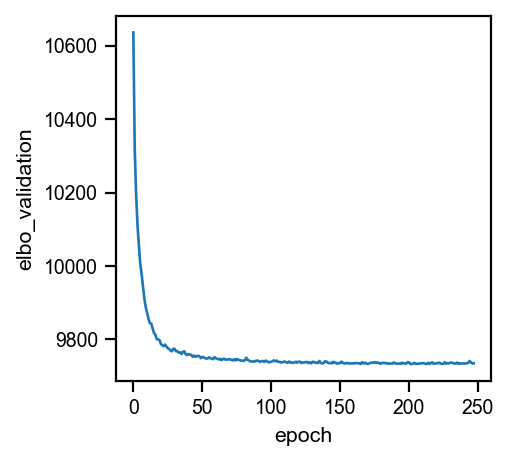

In [22]:
# Plot model ELBO
plt.figure(figsize=(3,3))
ax = sns.lineplot(model.history['elbo_validation'])
plt.ylabel("elbo_validation")
ax.get_legend().remove()
plt.show()

In [23]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

In [24]:
# Dimensionality reduction
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

... storing 'genotype' as categorical
... storing 'sample' as categorical
... storing 'cell_type' as categorical


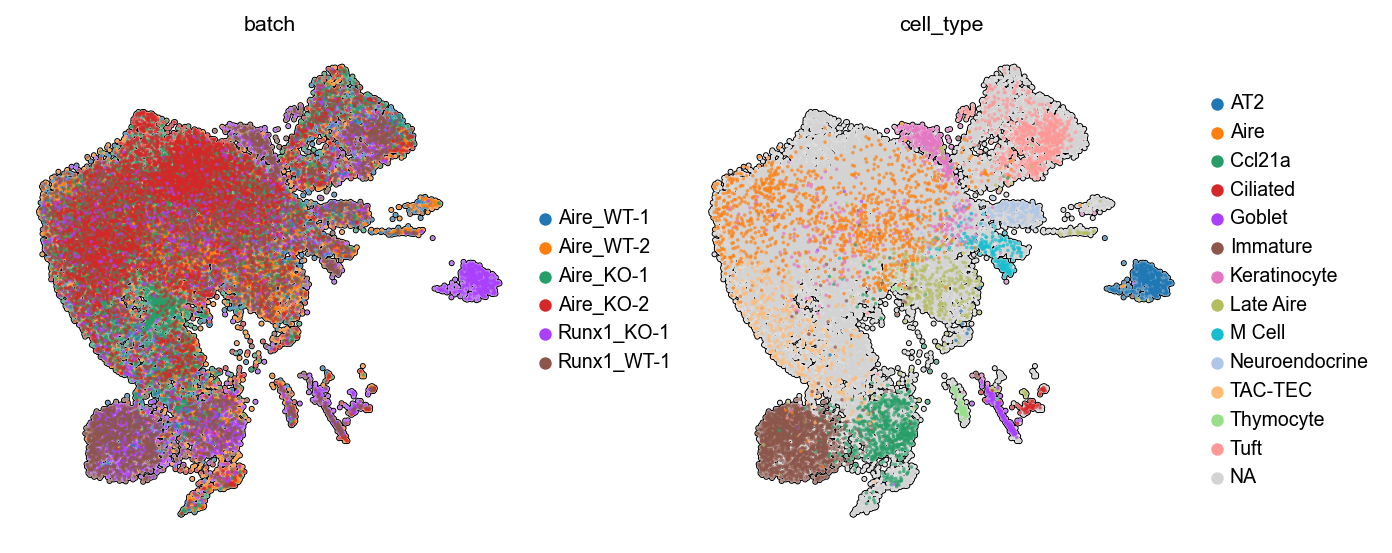

In [25]:
sc.pl.umap(
    adata,
    color=["batch", "cell_type"],
    s=10,
    add_outline=True,
)

# Label transfer

In [26]:
train_data = adata[adata.obs.batch.str.contains("Runx")].copy()
label_data = adata[adata.obs.batch.str.contains("Aire")].copy()

In [54]:
celltypist.__version__

'1.6.2'

In [27]:
# Feature selection
model_fs = celltypist.train(
    train_data,
    'cell_type',
    n_jobs = 10,
    max_iter = 5,
    use_SGD = True
)
gene_index = np.argpartition(np.abs(model_fs.classifier.coef_), -300, axis = 1)[:, -300:]
gene_index = np.unique(gene_index)
print(f"Number of genes selected: {len(gene_index)}")

🍳 Preparing data before training
✂️ 53 non-expressed genes are filtered out
🔬 Input data has 6729 cells and 15450 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
✅ Model training done!


Number of genes selected: 3418


In [28]:
# Train celltypist model
celltypist_model = celltypist.train(
    train_data[:, gene_index],
    'cell_type',
    n_jobs = 10,
    max_iter = 1000,
    check_expression = False,
)

🍳 Preparing data before training
✂️ 10 non-expressed genes are filtered out
🔬 Input data has 6729 cells and 3408 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
✅ Model training done!


In [29]:
# Get celltypist predictions
predictions = celltypist.annotate(
    label_data,
    model=celltypist_model,
    majority_voting=True
)

🔬 Input data has 26545 cells and 15503 genes
🔗 Matching reference genes in the model
🧬 3408 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [30]:
label_data = predictions.to_adata()
label_data.obs["cell_type"] = label_data.obs.majority_voting

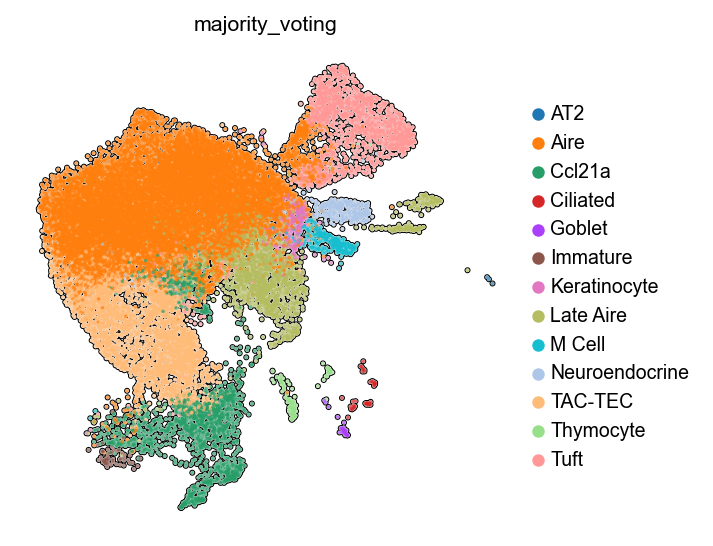

In [31]:
sc.pl.umap(
    label_data,
    color=["majority_voting"],
    s=10,
    add_outline=True,
)

In [32]:
adata = ad.concat([train_data, label_data])

In [33]:
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories([
    'Aire', 'AT2', 'Ccl21a', 'Ciliated', 'Goblet', 'Immature',
    'Keratinocyte', 'Late Aire', 'M Cell', 'Neuroendocrine',
    'TAC-TEC', 'Thymocyte', 'Tuft']
)

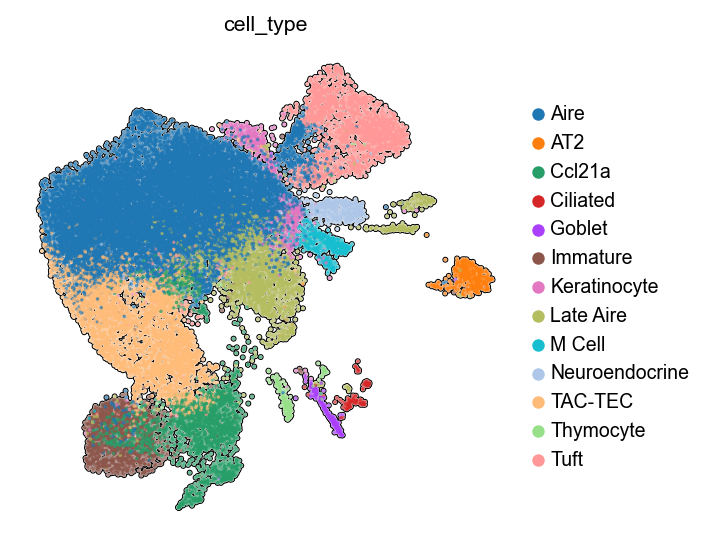

In [34]:
sc.settings.figdir = "../analysis"
sc.pl.umap(
    adata,
    color=["cell_type"],
    s=10,
    add_outline=True,
    save="_integrated_cell_types.pdf",
)

# AT2 abundance

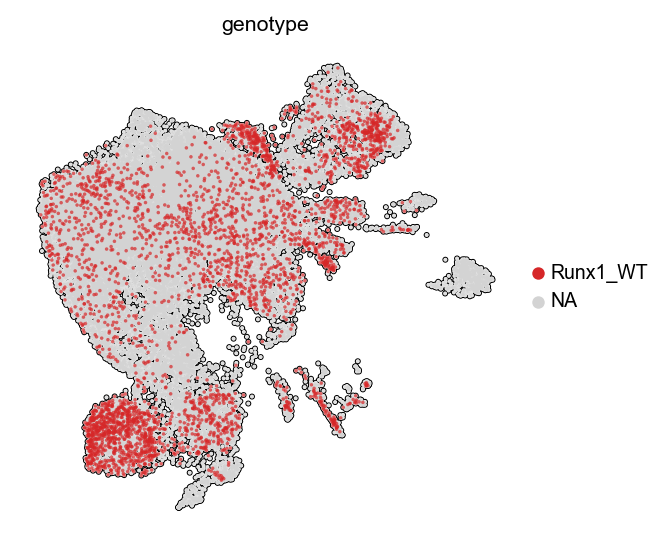

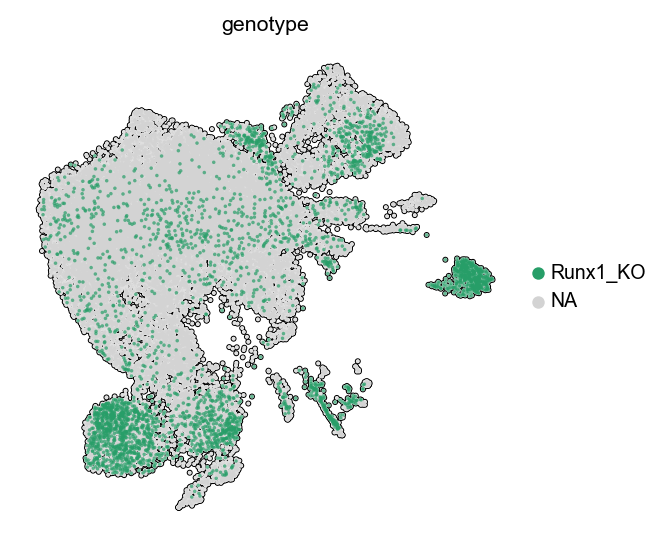

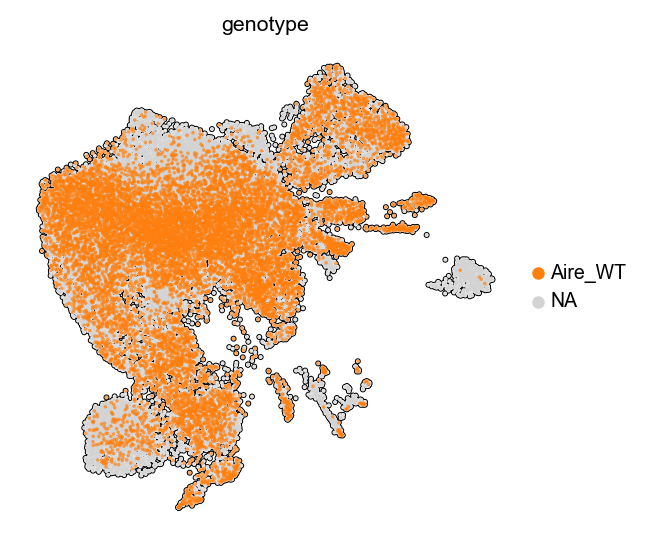

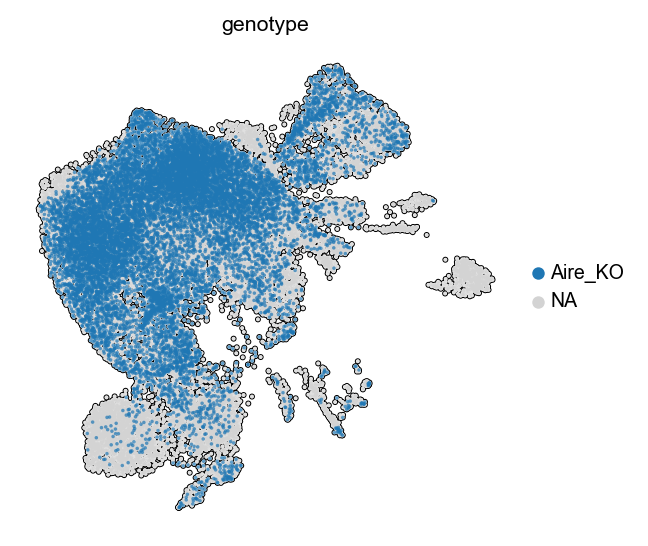

In [35]:
sc.settings.figdir = "../analysis"
sc.pl.umap(
    adata,
    color=["genotype"],
    groups="Runx1_WT",
    s=10,
    add_outline=True,
    save="_Runx1_WT.pdf",
)
sc.pl.umap(
    adata,
    color=["genotype"],
    groups="Runx1_KO",
    s=10,
    add_outline=True,
    save="_Runx1_KO.pdf",
)
sc.pl.umap(
    adata,
    color=["genotype"],
    groups="Aire_WT",
    s=10,
    add_outline=True,
    save="_Aire_WT.pdf",
)
sc.pl.umap(
    adata,
    color=["genotype"],
    groups="Aire_KO",
    s=10,
    add_outline=True,
    save="_Aire_KO.pdf",
)

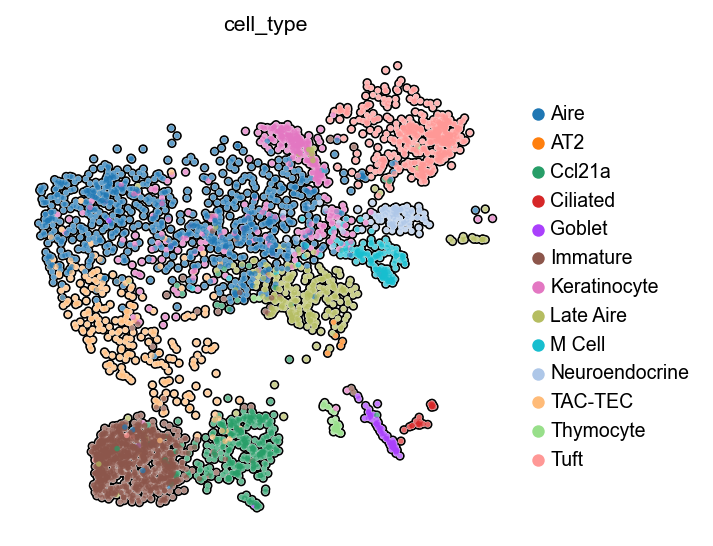

In [43]:
sc.settings.figdir = "../analysis"
sc.pl.umap(
    adata[adata.obs.genotype=="Runx1_WT"],
    color=["cell_type"],
    s=25,
    add_outline=True,
    save="_Runx1_WT_cell_types.pdf",
)

In [37]:
abundance_data = pd.DataFrame()
for genotype in adata.obs.genotype.unique():
    genotype_data = adata[adata.obs.genotype == genotype]
    cell_type_abundances = genotype_data.obs.cell_type.value_counts()
    cell_type_abundances = cell_type_abundances/genotype_data.shape[0]*100
    cell_type_abundances = pd.DataFrame(cell_type_abundances)
    cell_type_abundances = cell_type_abundances.reset_index()
    cell_type_abundances.columns = ["cell_type", "abundance"]
    cell_type_abundances["genotype"] = genotype
    abundance_data = pd.concat([abundance_data, cell_type_abundances], ignore_index=True)

In [38]:
abundance_data = abundance_data[abundance_data.cell_type == "AT2"]
abundance_data = pd.concat([abundance_data, pd.DataFrame(["AT2", 0, "Aire_KO"], index=["cell_type", "abundance", "genotype"]).T])
abundance_data.genotype = abundance_data.genotype.astype("category")

In [39]:
abundance_data.genotype = abundance_data.genotype.cat.reorder_categories(["Runx1_WT", "Runx1_KO", "Aire_WT", "Aire_KO"])

In [50]:
abundance_data = abundance_data.sort_values(by="genotype")

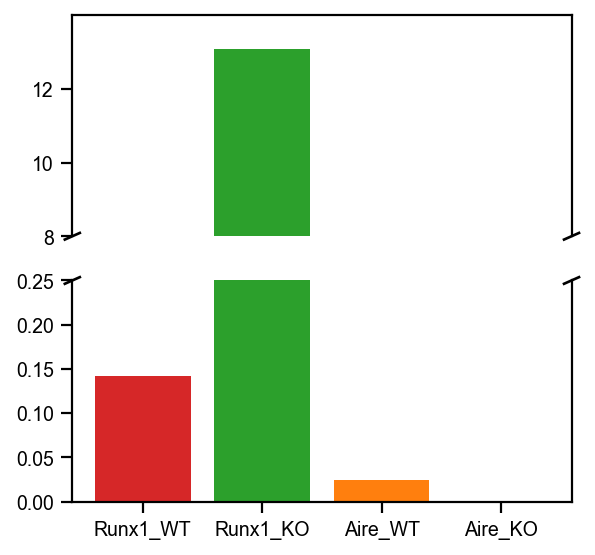

In [51]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(4,4))
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x',which='both',bottom=False)
ax2.spines['top'].set_visible(False)

bs = 500
ts = 1000

ax2.set_ylim(0,0.25)
ax1.set_ylim(8,14)
ax1.set_yticks(np.arange(8,14,2))

bars1 = ax1.bar(abundance_data.genotype, abundance_data.abundance, color=["tab:red", "tab:green", "tab:orange", "tab:blue"])
bars2 = ax2.bar(abundance_data.genotype, abundance_data.abundance, color=["tab:red", "tab:green", "tab:orange", "tab:blue"])

for tick in ax2.get_xticklabels():
    tick.set_rotation(0)
d = .015  
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)      
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

plt.savefig("../analysis/AT2_abundance.pdf")
plt.show()

In [45]:
for genotype in adata.obs.genotype.unique():
    print(genotype)
    print(adata[(adata.obs.genotype == genotype) & (adata.obs.cell_type == "AT2")].shape[0])

Runx1_KO
421
Runx1_WT
5
Aire_WT
3
Aire_KO
0


# Save data

In [46]:
# Check save paths
if not os.path.isdir(f"{processedDataPath}/Runx1_KO/scVI_models"):
    os.makedirs(f"{processedDataPath}/Runx1_KO/scVI_models")
    
if not os.path.isdir(f"{processedDataPath}/Runx1_KO/h5ad_files"):
    os.makedirs(f"{processedDataPath}/Runx1_KO/h5ad_files")
    
if os.path.isdir(f"{processedDataPath}/Runx1_KO/scVI_models/integrated"):
    shutil.rmtree(f"{processedDataPath}/Runx1_KO/scVI_models/integrated")
    
model.save(f"{processedDataPath}/Runx1_KO/scVI_models/integrated")
celltypist_model.write(f"{processedDataPath}/Runx1_KO/Runx1_thymus_celltypist_model.pkl")
adata.write(f"{processedDataPath}/Runx1_KO/h5ad_files/integrated.h5ad")